In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn.tree import export_text
import joblib

In [3]:
df = pd.read_csv('Data/preprocessed_dataset.csv')
df = df[["happiness_classification","fear","anger","surprise","sadness","disgust","joy","anticipation"]]
df.head()

,happiness_classification,fear,anger,surprise,sadness,disgust,joy,anticipation
0,not-happy,0.044010,0.029340,0.034230,0.031785,0.026895,0.056235,0.100244
1,not-happy,0.060606,0.028520,0.033868,0.035651,0.024955,0.057041,0.112299
2,happy,0.072381,0.049524,0.040000,0.038095,0.034286,0.097143,0.091429
3,not-happy,0.059840,0.043883,0.019947,0.041223,0.031915,0.070479,0.093085
4,happy,0.070225,0.043539,0.036517,0.036517,0.028090,0.081461,0.102528


In [4]:
le = LabelEncoder()
df["happiness_classification"] = le.fit_transform(df["happiness_classification"])
df["happiness_classification"] = df["happiness_classification"].replace({0: 1, 1: 0})
df.head()

,happiness_classification,fear,anger,surprise,sadness,disgust,joy,anticipation
0,0,0.044010,0.029340,0.034230,0.031785,0.026895,0.056235,0.100244
1,0,0.060606,0.028520,0.033868,0.035651,0.024955,0.057041,0.112299
2,1,0.072381,0.049524,0.040000,0.038095,0.034286,0.097143,0.091429
3,0,0.059840,0.043883,0.019947,0.041223,0.031915,0.070479,0.093085
4,1,0.070225,0.043539,0.036517,0.036517,0.028090,0.081461,0.102528


In [5]:
X = df.drop(columns=['happiness_classification'])
y = df['happiness_classification']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 5)
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Training features shape: (736, 7)
Testing features shape: (185, 7)


Average accuracy before hyperparameter tuning:  0.5310810810810811
Best hyperparameters:  {'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 5}
Best accuracy score from hyperparameter tuning  0.563939281747501
Accuracy on Test: 0.5837837837837838
Precision on Test: 0.5806451612903226
Recall on Test: 0.41379310344827586
F1 on Test: 0.4832214765100671
AUC 0.5802251935256861


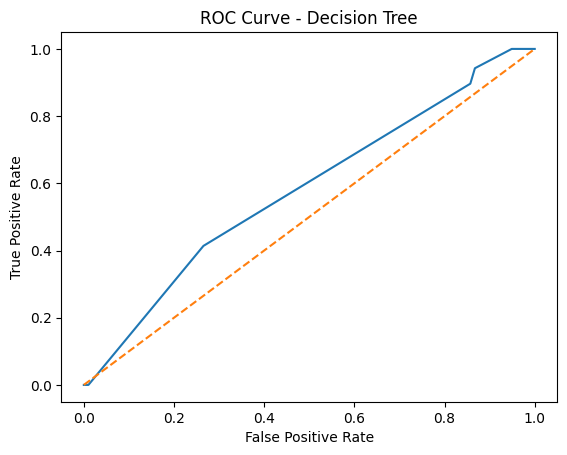

In [6]:
initial_dt = tree.DecisionTreeClassifier(random_state=5)

cv = KFold(n_splits=10, shuffle=True, random_state=5)

def run_cv(model, X, y, cv):

    accuracy_scores = []

    for train, val in cv.split(X, y):

        X_train_fold, X_val_fold = X.iloc[train], X.iloc[val]
        y_train_fold, y_val_fold = y.iloc[train], y.iloc[val]
        model.fit(X_train_fold, y_train_fold)
        y_pred_val_fold = model.predict(X_val_fold)

        accuracy_scores.append(accuracy_score(y_val_fold, y_pred_val_fold))

    average_accuracy_score = np.mean(accuracy_scores)

    return average_accuracy_score

init_average_accuracy = run_cv(initial_dt, X_train, y_train, cv)
print("Average accuracy before hyperparameter tuning: ", init_average_accuracy)

param_grid = {
    'max_depth': [1, 3, 5, 7, 10],
    'min_samples_split': [5, 10, 15, 20, 50],
    'min_samples_leaf':[1, 3, 5, 7, 10]
    } 

grid_search = GridSearchCV(initial_dt, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score from hyperparameter tuning ", grid_search.best_score_)

my_dt = tree.DecisionTreeClassifier(random_state=5,max_depth=3,min_samples_leaf=7,min_samples_split=5)
my_dt.fit(X_train, y_train)
y_pred_class = my_dt.predict(X_test)
y_pred_prob = my_dt.predict_proba(X_test)[:,1]

test_accuracy_score = accuracy_score(y_test, y_pred_class)
print("Accuracy on Test:", test_accuracy_score)
test_precision_score = precision_score(y_test, y_pred_class)
print("Precision on Test:", test_precision_score)
test_recall_score = recall_score(y_test, y_pred_class)
print("Recall on Test:", test_recall_score)
test_f1_score = f1_score(y_test, y_pred_class)
print("F1 on Test:", test_f1_score)
roc_auc_result = roc_auc_score(y_test, y_pred_prob)
print("AUC", roc_auc_result)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.show()

In [7]:
r = export_text(my_dt, feature_names=X_train.columns.tolist())
print(r)

|--- joy <= 0.07
|   |--- disgust <= 0.04
|   |   |--- fear <= 0.05
|   |   |   |--- class: 0
|   |   |--- fear >  0.05
|   |   |   |--- class: 1
|   |--- disgust >  0.04
|   |   |--- disgust <= 0.05
|   |   |   |--- class: 0
|   |   |--- disgust >  0.05
|   |   |   |--- class: 1
|--- joy >  0.07
|   |--- anger <= 0.03
|   |   |--- disgust <= 0.01
|   |   |   |--- class: 1
|   |   |--- disgust >  0.01
|   |   |   |--- class: 0
|   |--- anger >  0.03
|   |   |--- anger <= 0.08
|   |   |   |--- class: 0
|   |   |--- anger >  0.08
|   |   |   |--- class: 0



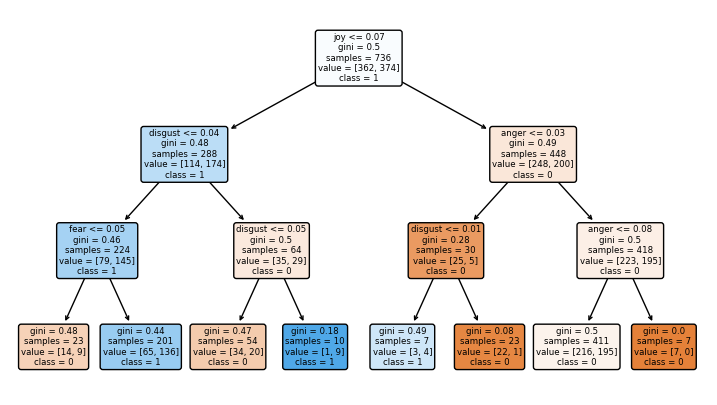

In [8]:
feature_names = X_train.columns.tolist()
plt.figure(figsize=(9, 5))
plot_tree(my_dt, filled=True, feature_names=feature_names, class_names=[str(target) for target in my_dt.classes_], rounded=True, precision=2)
plt.show()

In [10]:
joblib.dump(my_dt, 'Models/emotions_tree_clf.pkl')

['Models/emotions_tree_clf.pkl']